<a href="https://colab.research.google.com/github/ahmedbellaaj10/TP_ML_avance/blob/main/Lab_DL__RNN_CLASS__keras__2021_10_05__imdb__student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2021/10/05 (changed to tensorfow.keras)

For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [ ]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = True
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [ ]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [ ]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

17464789/17464789 [==============================] - 2s 0us/step


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists.
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test```
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000, 100)
type(X_train[0]): <class 'numpy.ndarray'>
length of the first training sequence: len(X_train[0]): 100
length of the second training sequence: len(X_train[1]): 100
list of data of the first training sequence: X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]
maximum length of a training sequence: 100


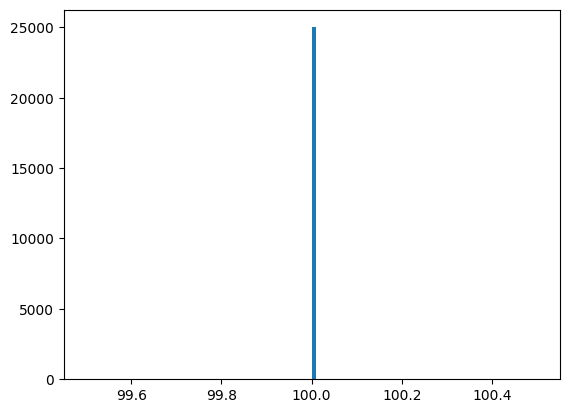

In [ ]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [ ]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

1641221/1641221 [==============================] - 1s 1us/step
the stone streets of <UNK> on his way to a date with destiny and the game br br star kurt thomas was ill served by director robert <UNK> who it looks like was never on the set the so called script is just this side of incompetent see other reviews for the many <UNK> throughout the town of <UNK> has a few good moments but is ultimately ruined by bad editing the ending <UNK> still there's the <UNK> of a good action adventure here a hong kong version with more <UNK> action and faster pace might even be pretty good


In [ ]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [ ]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [ ]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    ...
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence,
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [ ]:
K.clear_session()

In [ ]:
X_train[0]

In [ ]:
# --- create the model
# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    ...
    # --- END CODE HERE

    # --- START CODE HERE (03)
    # --- Using the Functional API
    ...
    # --- END CODE HERE

print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 100, 32)           160000    
                                                                 
 lambda_11 (Lambda)          (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
 activation_7 (Activation)   (None, 1)                 0         
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 33s 71ms/step - loss: 0.6394 - accuracy: 0.7346 - val_loss: 0.5624 - val_accuracy: 0.7737
Epoch 2/3
391/391 [==============================] - 7s 19ms/step - loss: 0.4866 - accuracy: 0.8163 - val_loss: 0.4405 - val_accuracy: 0.8236
Epoch 3/3
391/391 [==============================] - 4s 10ms/step - loss: 0.3940 - accuracy: 0.8453 - val_loss: 0.3858 - val_accuracy: 0.8346


## Results

After only 3 epochs, you should obtain an accuracy around 83-84% for the test data.

In [ ]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.46%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [ ]:
model.layers[0].get_weights()[0].shape

In [ ]:
if student:
    # --- START CODE HERE (04)
    ...
    # --- END CODE HERE
for i in np.argsort(dist_v)[0:20]: print(id_to_word[i])

great
excellent
perfect
7
wonderful
highly
8
amazing
superb
best
favorite
loved
fantastic
9
recommended
brilliant
today
love
enjoyed
definitely


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [ ]:
K.clear_session()

In [ ]:
# --- create the model

if student:
    # --- START CODE HERE (05)
    # --- Using the Sequential API
    ...
    # --- END CODE HERE

    # --- START CODE HERE (06)
    # --- Using the Functional API
    #model = ...
    # --- END CODE HERE

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 100, 32)           160000    
                                                                 
 lstm_13 (LSTM)              (None, 128)               82432     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
 activation_16 (Activation)  (None, 1)                 0         
                                                                 
Total params: 242561 (947.50 KB)
Trainable params: 242561 (947.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 28s 62ms/step - loss: 0.4480 - accuracy: 0.7796 - val_loss: 0.3460 - val_accuracy: 0.8487
Epoch 2/3
391/391 [==============================] - 8s 20ms/step - loss: 0.3075 - accuracy: 0.8718 - val_loss: 0.3634 - val_accuracy: 0.8445
Epoch 3/3
391/391 [==============================] - 8s 20ms/step - loss: 0.2736 - accuracy: 0.8888 - val_loss: 0.3553 - val_accuracy: 0.8470


## Results

After only 3 epochs, you should obtain an accuracy around 84-85% for the test data.

In [ ]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Evaluation

To evaluate the work, you should rate the code for
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
